# Examen Segundo Parcial (Práctico)
### Laboratorio de Aprendizaje Estadístico

José Armando Melchor Soto  | 745697

--- 




### Librerías: 

In [ ]:
import pandas as pd
from sklearn.neighbors import KNeighborsRegressor 
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
import numpy as np
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from sklearn import linear_model
import statsmodels.formula.api as smf
import warnings
import numpy as np
from scipy import stats
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss
from sklearn import discriminant_analysis, neighbors
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_curve
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

warnings.simplefilter(action='ignore', category=FutureWarning)

colors = ["cornflowerblue", "indianred", "darkseagreen", "plum", "dimgray"]

---

### Dataset : 
Recursos Humanos

In [206]:
df= pd.read_csv('hr_role.csv')

In [207]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 33 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EnvironmentSatisfaction   1470 non-null   int64 
 9   Gender                    1470 non-null   object
 10  HourlyRate                1470 non-null   int64 
 11  JobInvolvement            1470 non-null   int64 
 12  JobLevel                  1470 non-null   int64 
 13  JobRole                   1470 non-null   object
 14  MaritalStatus           

### Visualización del Dataset

In [208]:
df.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,...,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,is_satisfied
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,2,Female,...,80,0,8,0,1,6,4,0,5,True
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,3,Male,...,80,1,10,3,3,10,7,1,7,False
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,4,Male,...,80,0,7,3,3,0,0,0,0,False
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,4,Female,...,80,0,8,3,3,8,7,3,0,False
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,Male,...,80,1,6,3,3,2,2,2,2,False


### Explicación de las variables

---

#### Se busca predecir si está satisfecho

In [209]:
df['is_satisfied']

0        True
1       False
2       False
3       False
4       False
        ...  
1465     True
1466    False
1467    False
1468    False
1469    False
Name: is_satisfied, Length: 1470, dtype: bool

In [210]:
target= 'is_satisfied'
y= df[target]

In [211]:
len(df[df['is_satisfied'] == 1]), len(df[df['is_satisfied'] == 0])

(459, 1011)

#### Dummies

In [212]:
df= pd.get_dummies(df, drop_first=True)

#### NaN's

In [213]:
pd.DataFrame(df.isnull().sum()).T

,Age,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,MonthlyIncome,MonthlyRate,...,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Married,MaritalStatus_Single,OverTime_Yes
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [214]:
df.isna().sum()

Age                                  0
DailyRate                            0
DistanceFromHome                     0
Education                            0
EnvironmentSatisfaction              0
HourlyRate                           0
JobInvolvement                       0
JobLevel                             0
MonthlyIncome                        0
MonthlyRate                          0
NumCompaniesWorked                   0
PercentSalaryHike                    0
PerformanceRating                    0
RelationshipSatisfaction             0
StandardHours                        0
StockOptionLevel                     0
TotalWorkingYears                    0
TrainingTimesLastYear                0
WorkLifeBalance                      0
YearsAtCompany                       0
YearsInCurrentRole                   0
YearsSinceLastPromotion              0
YearsWithCurrManager                 0
is_satisfied                         0
Attrition_Yes                        0
BusinessTravel_Travel_Fre

Ninguna Variable tiene NaN's , así que podemos continuar

#### Función Calibración 

In [216]:
def calibracion(predicciones, y, bins):
    df_calibracion = pd.DataFrame({
        'predicciones': predicciones,
        'y': y
    })
    
    df_calibracion['bins'] = pd.qcut(df_calibracion['predicciones'], q=bins, labels=False) + 1
    gropuped = df_calibracion.groupby('bins').mean()
    
    plt.plot(gropuped.predicciones, gropuped.y, label="Modelo", marker="o")
    plt.plot(gropuped.predicciones, gropuped.predicciones, label="Real", marker="o")
    plt.grid()
    plt.legend()
    plt.xlabel("Prediccion")
    plt.ylabel("Real")

#### **Modelo**

Se pide que el modelo tenga: 

test set: 20%
random_state: 42

In [218]:
X = df.drop(target, axis=1)
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

#### Feature Engineering

#### CrossValidation

##### - Gridsearch

##### - Random search

#### Correlación con la variable

In [220]:
df.corr()["is_satisfied"].sort_values(ascending=False)

is_satisfied                         1.000000
EducationField_Life Sciences         0.044076
PercentSalaryHike                    0.042461
Gender_Male                          0.040752
OverTime_Yes                         0.039452
JobRole_Sales Executive              0.036071
PerformanceRating                    0.034319
MaritalStatus_Single                 0.032247
Department_Sales                     0.024711
BusinessTravel_Travel_Frequently     0.024431
StockOptionLevel                     0.023456
Tiempo empresa/experencia            0.018817
EnvironmentSatisfaction              0.017072
Tiempo en la empresa                 0.015242
JobRole_Research Scientist           0.014072
TrainingTimesLastYear                0.010379
EducationField_Other                 0.008929
Tiempo en el puesto/edad             0.007047
JobRole_Manager                      0.006649
EducationField_Marketing             0.006395
Tiempo empresa/edad                  0.006304
DailyRate                         

### **Modelos**

#### KNN Clasificador
---

##### - Random Search

In [321]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier())
])

param_dist = {
    'knn__n_neighbors': range(1, 200),
    'knn__weights': ['uniform', 'distance'],
    'knn__p': [1, 2]  # Manhattan (1) and Euclidean (2) distance
}

random_search = RandomizedSearchCV(pipeline, param_distributions=param_dist, n_iter=1000, cv=5, n_jobs=-1)
random_search.fit(X_train, y_train)


random_search.best_params_
probabilidades_knn = random_search.predict_proba(X_test)[:, 1]

print(random_search.best_params_)

c:\Users\ppmel\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 796 is smaller than n_iter=1000. Running 796 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


{'knn__weights': 'uniform', 'knn__p': 2, 'knn__n_neighbors': 36}


##### - Gridsearch

In [327]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier())
])

param_grid = {
    'knn__n_neighbors': range(1, 200),
    'knn__weights': ['uniform', 'distance'],
    'knn__p': [1, 2]  # Manhattan, Euclidean
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, scoring='roc_auc')

grid_search.fit(X_train, y_train)

probabilidades_knn2 = grid_search.predict_proba(X_test)[:, 1]



#### Regresión Logística
---

##### Polinomica 2

In [222]:
pipeline = Pipeline([
     ('scaler', StandardScaler()),
     ('poly_features', PolynomialFeatures(degree=2)),
     ('model', linear_model.LogisticRegression(penalty='l2'))
])

pipeline.fit(X_train, y_train)
probabilidades_modelo2 = pipeline.predict_proba(X_test)[:, 1]

c:\Users\ppmel\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


##### Polinomica 3

In [223]:
pipeline = Pipeline([
     ('scaler', StandardScaler()),
     ('poly_features', PolynomialFeatures(degree=3)),
     ('model', linear_model.LogisticRegression(penalty='l2'))
])

pipeline.fit(X_train, y_train)
probabilidades_modelo3 = pipeline.predict_proba(X_test)[:, 1]

##### Red Neuronal

In [224]:
# Pipeline
pipeline= Pipeline([
    ('scaler', StandardScaler()),
    ('nn', MLPClassifier())
])
# Params grid
params_grid= {
    'nn__hidden_layer_sizes': [(100,100),(100,100,100)], 
    'nn__activation':['relu'],
    'nn__alpha': [0.01],
}
# Fit 
grid_nn= GridSearchCV(estimator=pipeline, param_grid=params_grid, cv=5, scoring='roc_auc', n_jobs=-1)
grid_nn.fit(X_train, y_train)

#AUC
grid_nn.fit(X_train, y_train)
predicciones_nn_prob = grid_nn.best_estimator_.predict_proba(X_test)[:, 1]

##### Analisis de Discriminante Lineal

In [225]:
pipeline = Pipeline([
     ('scaler', StandardScaler()),
     ('model', discriminant_analysis.LinearDiscriminantAnalysis())
])

pipeline.fit(X_train, y_train)
probabilidades_modelo_disc = pipeline.predict_proba(X_test)[:, 1]

##### Juntos

In [325]:
juntos = pd.DataFrame({
     'real': y_test,
     'logistica1': probabilidades_modelo1,
     'logistica2': probabilidades_modelo2,
     'logistica3': probabilidades_modelo3,
     'probabilidades_disc': probabilidades_modelo_disc,
     'probabilidades_neural': predicciones_nn_prob,
     'probabilidades_knn': probabilidades_knn,
     'probabilidades_knn2': probabilidades_knn2
})

juntos.head()

,real,logistica1,logistica2,logistica3,probabilidades_disc,probabilidades_neural,probabilidades_knn,probabilidades_knn2
515,False,0.341905,0.6,0.998685,0.335046,1.158869e-01,0.361111,0.324873
306,False,0.329907,0.2,0.009282,0.428238,1.615912e-03,0.388889,0.365482
1255,False,0.358675,0.8,0.855859,0.329757,9.997134e-01,0.444444,0.345178
378,True,0.243640,0.0,0.000020,0.167808,4.658178e-04,0.361111,0.314721
332,False,0.251996,0.4,0.001156,0.358524,3.054298e-07,0.333333,0.309645


In [ ]:
# Bins
bins = 5
juntos['bins_log1'] = pd.qcut(juntos['logistica1'], bins, labels=False) + 1
juntos['bins_log2'] = pd.qcut(juntos['logistica2'], bins, labels=False) + 1
juntos['bins_log3'] = pd.qcut(juntos['logistica3'], bins, labels=False) + 1
juntos['bins_disc'] = pd.qcut(juntos['probabilidades_disc'], bins, labels=False) + 1
juntos['bins_neural'] = pd.qcut(juntos['probabilidades_neural'], bins, labels=False) + 1


# Agrupaciones
grouped_log1 = juntos.groupby('bins_log1').mean()
grouped_log2 = juntos.groupby('bins_log2').mean()
grouped_log3 = juntos.groupby('bins_log3').mean()
grouped_disc = juntos.groupby('bins_disc').mean()
grouped_neural = juntos.groupby('bins_neural').mean()

### **Histograma, Calibración, roc AUC y AUC por modelo**

#### KNN Clasificador




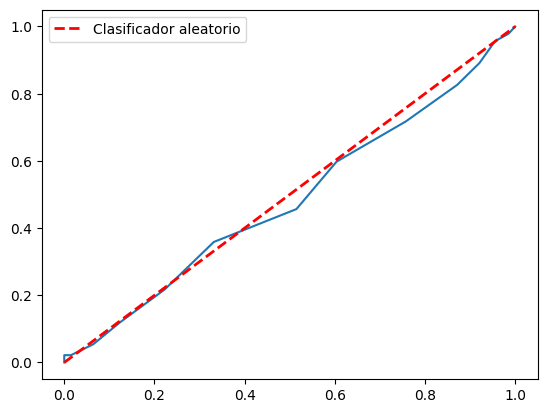

In [328]:
fpr, fnp, scores = roc_curve(y_score=probabilidades_knn, y_true=y_test)
plt.plot(fpr, fnp)
plt.plot([0, 1], [0, 1], color='red', linestyle='--', lw=2, label='Clasificador aleatorio')
plt.legend()


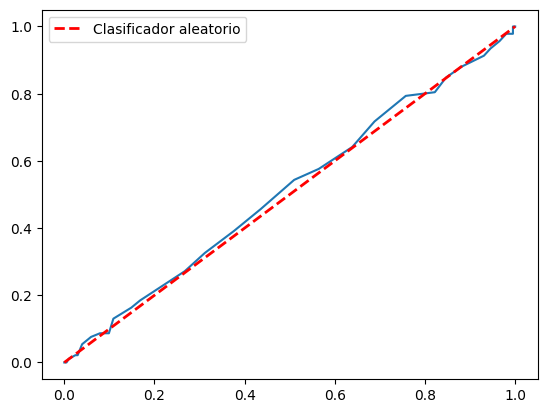

In [329]:
fpr, fnp, scores = roc_curve(y_score=probabilidades_knn2, y_true=y_test)
plt.plot(fpr, fnp)
plt.plot([0, 1], [0, 1], color='red', linestyle='--', lw=2, label='Clasificador aleatorio')
plt.legend()


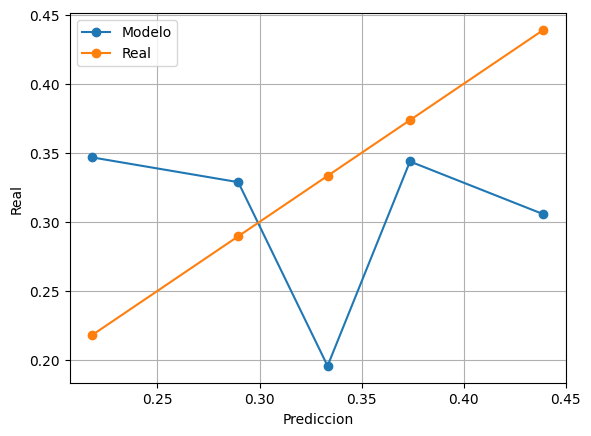

In [335]:
calibracion(probabilidades_knn, y_test, 5)

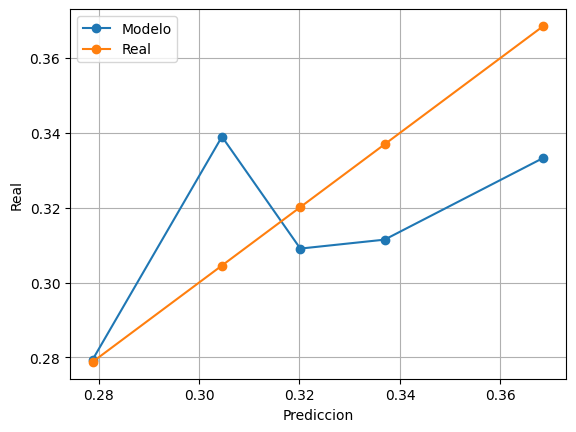

In [336]:
calibracion(probabilidades_knn2, y_test, 5)

In [337]:
print('AUC RandomSearch: ',roc_auc_score(y_score= probabilidades_knn, y_true=y_test))
print('AUC Gridsearch: ',roc_auc_score(y_score= probabilidades_knn2, y_true=y_test))

AUC RandomSearch:  0.48380327163151093
AUC Gridsearch:  0.5111924235901851


##### Regresión Logistica

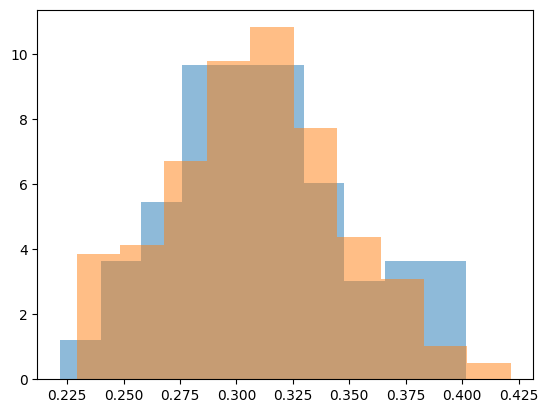

In [228]:
plt.hist(juntos[juntos.real == 1].logistica1, density=True, alpha=0.5, bins=10)
plt.hist(juntos[juntos.real == 0].logistica1, density=True, alpha=0.5, bins=10)
plt.show()

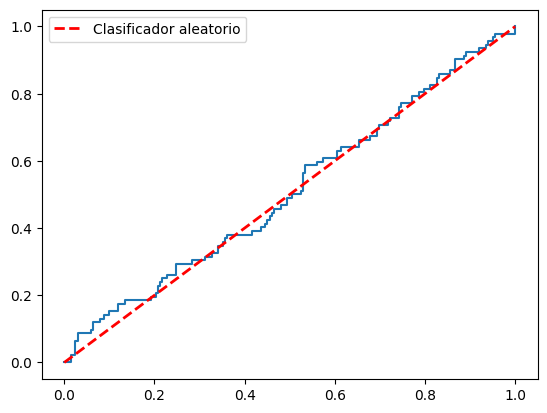

In [229]:
fpr, fnp, scores = roc_curve(y_score=probabilidades_modelo1, y_true=y_test)
plt.plot(fpr, fnp)
plt.plot([0, 1], [0, 1], color='red', linestyle='--', lw=2, label='Clasificador aleatorio')
plt.legend()


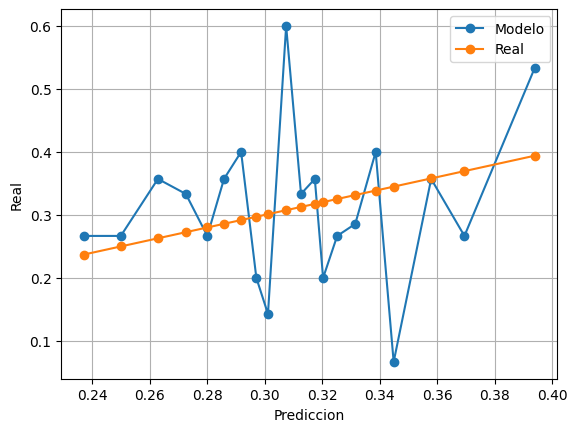

In [230]:
calibracion(probabilidades_modelo1, y_test, 20)

In [231]:
print('AUC: ',roc_auc_score(y_score= probabilidades_modelo1, y_true=y_test))

AUC:  0.5103314679294016


##### Polinomica 2

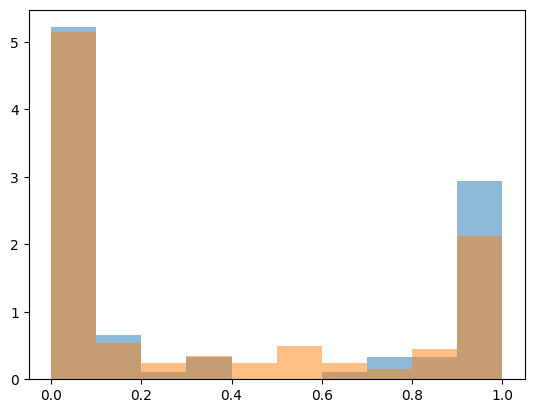

In [232]:
plt.hist(juntos[juntos.real == 1].logistica2, density=True, alpha=0.5, bins=10)
plt.hist(juntos[juntos.real == 0].logistica2, density=True, alpha=0.5, bins=10)
plt.show()

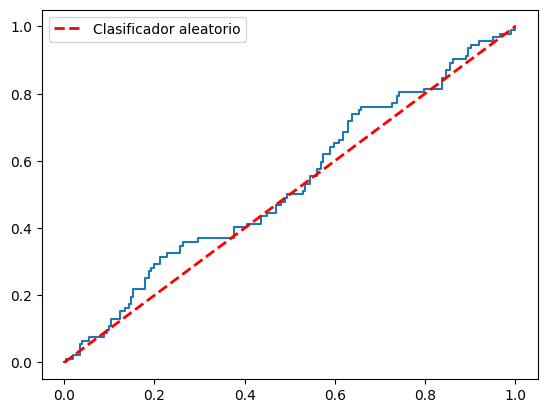

In [233]:
fpr, fnp, scores = roc_curve(y_score=probabilidades_modelo2, y_true=y_test)
plt.plot(fpr, fnp)
plt.plot([0, 1], [0, 1], color='red', linestyle='--', lw=2, label='Clasificador aleatorio')
plt.legend()


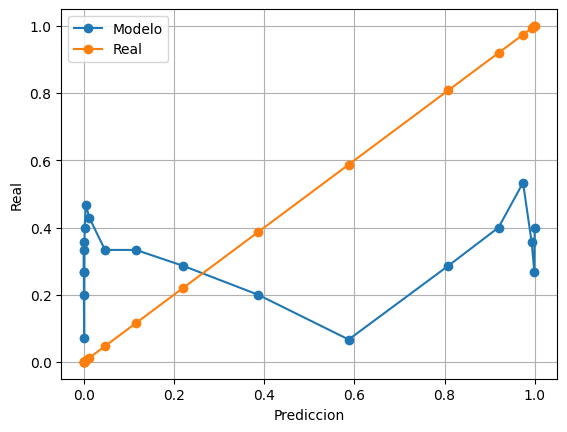

In [234]:
calibracion(probabilidades_modelo2, y_test, 20)

In [235]:
print('AUC: ',roc_auc_score(y_score= probabilidades_modelo2, y_true=y_test))

AUC:  0.5298105897546277


##### Polinomial  Grado 3

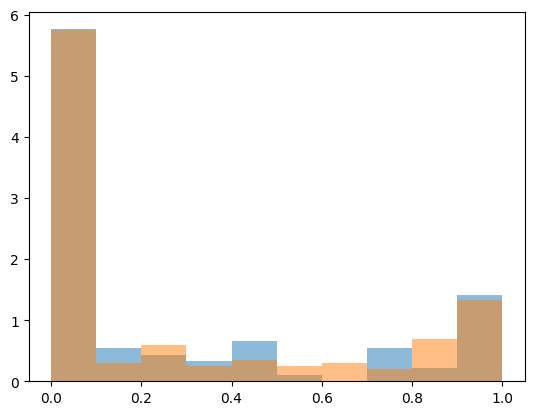

In [236]:
plt.hist(juntos[juntos.real == 1].logistica3, density=True, alpha=0.5, bins=10)
plt.hist(juntos[juntos.real == 0].logistica3, density=True, alpha=0.5, bins=10)
plt.show()

AUC:  0.4892380542402067


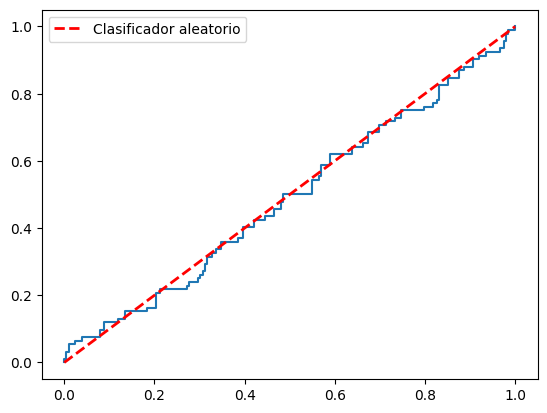

In [237]:
fpr, fnp, scores = roc_curve(y_score=probabilidades_modelo3, y_true=y_test)
plt.plot(fpr, fnp)
plt.plot([0, 1], [0, 1], color='red', linestyle='--', lw=2, label='Clasificador aleatorio')
plt.legend()
print('AUC: ',roc_auc_score(y_score= probabilidades_modelo3, y_true=y_test))

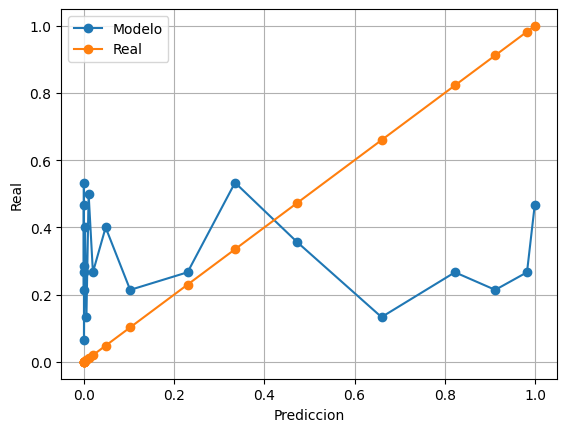

In [238]:
calibracion(probabilidades_modelo3, y_test, 20)

In [239]:
print('AUC: ',roc_auc_score(y_score= probabilidades_modelo3, y_true=y_test))

AUC:  0.4892380542402067


#### Red Neuronal

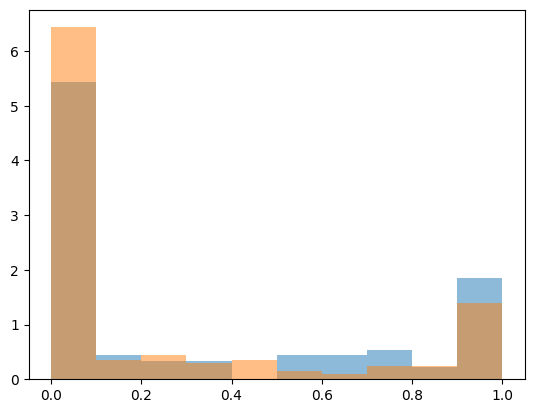

In [240]:
plt.hist(juntos[juntos.real == 1].probabilidades_neural, density=True, alpha=0.5, bins=10)
plt.hist(juntos[juntos.real == 0].probabilidades_neural, density=True, alpha=0.5, bins=10)
plt.show()

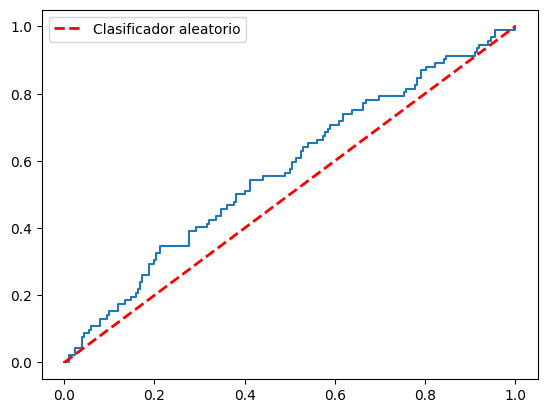

In [241]:
fpr, fnp, scores = roc_curve(y_score=predicciones_nn_prob, y_true=y_test)
plt.plot(fpr, fnp)
plt.plot([0, 1], [0, 1], color='red', linestyle='--', lw=2, label='Clasificador aleatorio')
plt.legend()

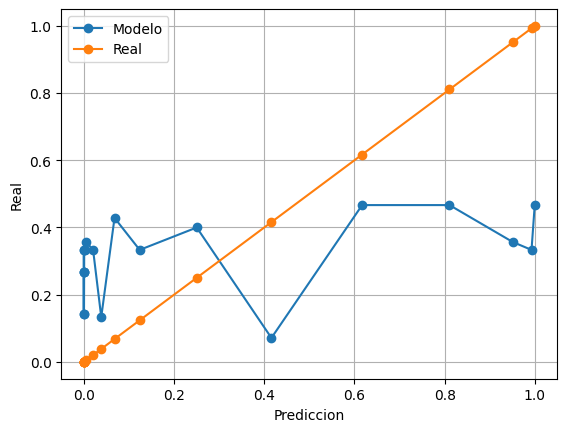

In [242]:
calibracion(predicciones_nn_prob, y_test, 20)

In [243]:
print('AUC:', roc_auc_score(y_score=predicciones_nn_prob, y_true=y_test))

AUC: 0.571190271201033


##### Discriminante Lineal

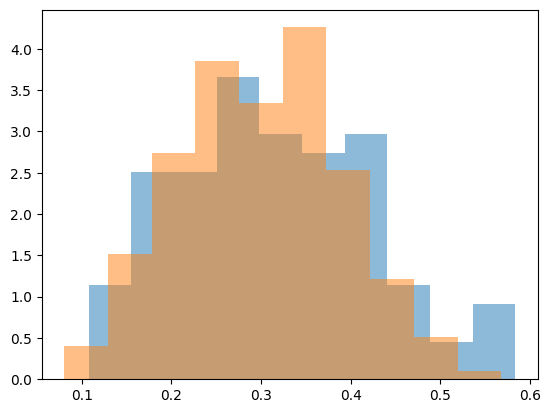

In [244]:
plt.hist(juntos[juntos.real == 1].probabilidades_disc, density=True, alpha=0.5, bins=10)
plt.hist(juntos[juntos.real == 0].probabilidades_disc, density=True, alpha=0.5, bins=10)
plt.show()

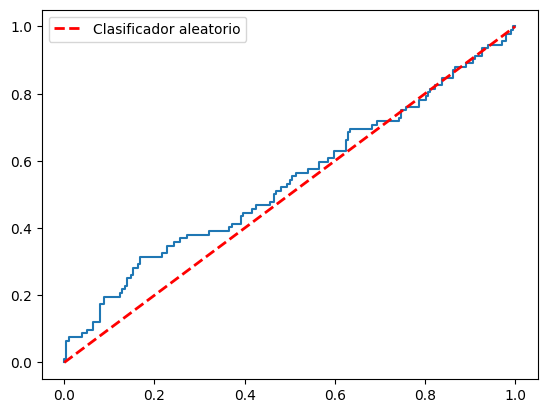

In [245]:
fpr, fnp, scores = roc_curve(y_score=probabilidades_modelo_disc, y_true=y_test)
plt.plot(fpr, fnp)
plt.plot([0, 1], [0, 1], color='red', linestyle='--', lw=2, label='Clasificador aleatorio')
plt.legend()

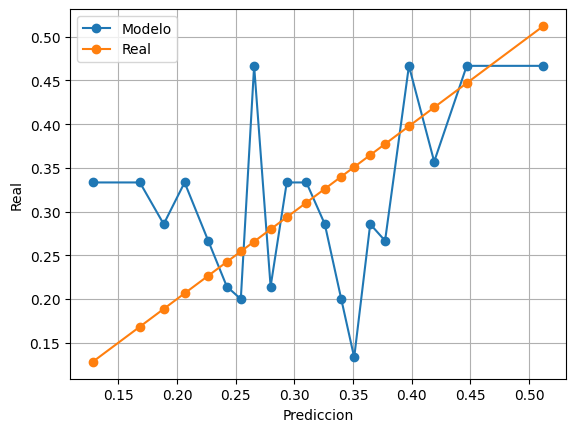

In [246]:
calibracion(probabilidades_modelo_disc, y_test, 20)

In [247]:
print('AUC: ',roc_auc_score(y_score= probabilidades_modelo_disc, y_true=y_test))

AUC:  0.5391196728368489


##### Juntos

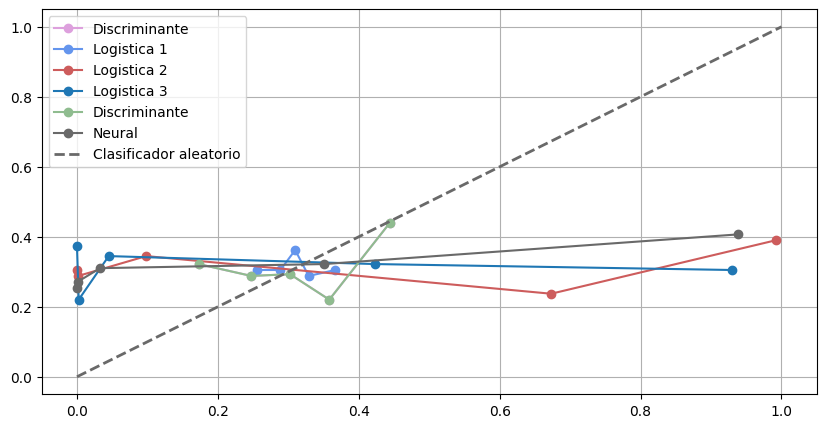

In [248]:
## Grafico de modelos
plt.figure(figsize=(10, 5))
plt.plot(grouped_disc.probabilidades_disc, grouped_disc.real, marker='o', label='Discriminante', color=colors[3])
plt.plot(grouped_log1.logistica1, grouped_log1.real, marker='o', label='Logistica 1', color=colors[0])
plt.plot(grouped_log2.logistica2, grouped_log2.real, marker='o', label='Logistica 2', color=colors[1])
plt.plot(grouped_log3.logistica3, grouped_log3.real, marker='o', label='Logistica 3' )
plt.plot(grouped_disc.probabilidades_disc, grouped_disc.real, marker='o', label='Discriminante', color=colors[2])
plt.plot(grouped_neural.probabilidades_neural, grouped_neural.real, marker='o', label='Neural', color=colors[4])
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, label='Clasificador aleatorio', color=colors[-1])
plt.legend()
plt.grid()
